In [1]:
import cufflinks as cf
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
from ta import add_all_ta_features
from ta.utils import dropna
from _lumber_prices import get_lumber_db_xl

# FETCH Data

In [ ]:
def add_technical_indicators(TA_df):

    TA_df.columns = ['Open','High','Low','Close','Volume','OpenInterest']
    TA_df = dropna(TA_df)
    TA_df.sort_index(ascending=True, inplace=True)
    TA_df = add_all_ta_features(TA_df, open="Open", high="High", low="Low", close="Close", volume="Volume")
    TA_df.sort_index(ascending=False, inplace=True)
    TA_df.drop(['Open','High','Low','Close','Volume','OpenInterest'],axis=1,inplace=True)
    TA_df.columns = [('TA_',x) for x in TA_df.columns]
    TA_df = TA_df.replace([np.inf, -np.inf], np.nan).fillna(TA_df.mean())
    return TA_df

# This func combines all trading dates from Barchart (historical) and cwp live lumber trading dates
def lumber_trading_days():
    barchart_idx = pd.DatetimeIndex(pd.DataFrame(pd.read_csv('F:/Traders/2x4/Adjusted CME Futures/Switch_OI/Lumber.csv',index_col=0)).index)
    cwp_idx = get_lumber_db_xl()[1].index
    cwp_idx = cwp_idx[cwp_idx>barchart_idx[0]]
    return cwp_idx.append(barchart_idx).sort_values(ascending=False)


# 
file_path = 'C:/source/2x4-data/app/model_building/daily_dataframe_main.xlsx'
### Reading Data from Excel daily_dataframe_main - Takes 1 min 40 secs to run
Variables = pd.read_excel(file_path, header=[0,1], sheet_name='Variables',index_col=0)
Response = pd.read_excel(file_path,sheet_name= 'Response' ,index_col=0)
TA_df = Variables.loc[:,('Lumber_Adjusted_dfs',)][['Adj_open3','Adj_high3','Adj_low3','Adj_close3','volume3','openInterest3']]
TA_df = add_technical_indicators(TA_df)
TA_df.replace([np.inf, -np.inf], np.nan, inplace=True)
TA_df.fillna(method='bfill', inplace=True)

Variables.sort_index(ascending = False, inplace = True)
Response.sort_index(ascending = False, inplace = True)

cme = mcal.get_calendar("CME_Agriculture")
cme_trading_days = cme.schedule(start_date=Variables.index[-1].date(), end_date=Variables.index[0].date()).index
cme_trading_days = cme_trading_days.sort_values(ascending=False)
cme_trading_days = pd.DatetimeIndex(cme_trading_days)

trading_days = lumber_trading_days()
# Variables = Variables[Variables.index > '2012-01-01']
Variables = Variables[Variables.index.isin(cme_trading_days)]
Variables = Variables[Variables.index.isin(trading_days)]

# Response = Response[Response.index > '2012-01-01']
Response = Response[Response.index.isin(cme_trading_days)]
Response = Response[Response.index.isin(trading_days)]
# Response = Response[(Response.Close_Up_Down == 1) | (Response.Close_Up_Down == -1)]

Variables.index = pd.DatetimeIndex(Variables.index)
Response.index = pd.DatetimeIndex(Response.index)
Variables = Variables.reindex(Response.index)

Variables.drop(Variables.columns[Variables.isna().all()].to_list(), axis=1, inplace=True)
Variables.drop(Variables.columns[Variables.isnull().all()].to_list(), axis=1, inplace=True)

Response.drop(Response.columns[Response.isna().all()].to_list(), axis=1, inplace=True)
Response.drop(Response.columns[Response.isnull().all()].to_list(), axis=1, inplace=True)

In [8]:
Lumber_OHLCVI = Variables.loc[:,('Lumber_Adjusted_dfs',)][['Adj_open3','Adj_high3','Adj_low3','Adj_close3','volume3','openInterest3']]
Lumber_OHLCVI.columns = ['Open','High','Low','Close','Volume','OpenInterest']
Lumber_OHLCVI = Lumber_OHLCVI.shift(1)
# Lumber_OHLCVI.dropna(inplace=True)
Lumber_OHLCVI

,Open,High,Low,Close,Volume,OpenInterest
2022-08-15,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-12,595.599976,611.400024,583.799988,588.700012,219.0,1569.0
2022-08-11,601.799988,635.599976,577.099976,595.599976,647.0,1654.0
2022-08-10,552.799988,601.799988,573.000000,601.799988,487.0,1808.0
2022-08-09,519.299988,565.000000,528.400024,552.799988,376.0,1895.0
...,...,...,...,...,...,...
1969-10-07,4084.353631,4033.299211,3982.244790,4033.299211,NaN,NaN
1969-10-06,4084.353631,4109.880841,4084.353631,4084.353631,NaN,NaN
1969-10-03,4109.880841,4084.353631,4084.353631,4084.353631,NaN,NaN
1969-10-02,4084.353631,4109.880841,4058.826421,4109.880841,NaN,NaN


In [10]:
data = Lumber_OHLCVI.copy()
data = data.Close.to_frame()
data.columns = ['Price']
data.sort_index(ascending=True, inplace=True)
data.dropna(inplace=True)
data.head(2).append(data.tail(2))

,Price
1969-10-01,4084.353631
1969-10-02,4109.880841
2022-08-11,595.599976
2022-08-12,588.700012


In [4]:
from scipy.optimize import minimize, brute

### SMABacktester Class

In [286]:
class SMABacktester():
    def __init__(self, symbol, SMA_S, SMA_L, start, end, tc):
        self.symbol = symbol
        self.SMA_S = SMA_S
        self.SMA_L = SMA_L
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()

    def __repr__(self):
        repr = "SMABacktester(sybmol={}, SMA_S={}, SMA_L={}, start={}, end={})".format(self.symbol, self.SMA_S, self.SMA_L, self.start, self.end)
        return repr
        
    def get_data(self):
        '''Retrives and Prepares the data...

        Parameters
        ==========
        None
        '''

        data = Lumber_OHLCVI.copy()
        data = data.Close.to_frame().dropna()
        data.columns = ['Price']
        data.sort_index(ascending=True, inplace=True)
        data = data.loc[self.start:self.end]
        data['returns'] = np.log(data.Price/data.Price.shift(1))
        data.dropna(inplace=True)
        data['SMA_S'] = data['Price'].rolling(self.SMA_S).mean()
        data['SMA_L'] = data['Price'].rolling(self.SMA_L).mean()
        self.data = data
        # return data

    def set_parameters(self,SMA_S = None, SMA_L = None):
        if SMA_S is not None:
            self.SMA_S = SMA_S
            self.data.SMA_S = self.data['Price'].rolling(self.SMA_S).mean()
        if SMA_L is not None:
            self.SMA_L = SMA_L
            self.data.SMA_L = self.data['Price'].rolling(self.SMA_L).mean()
    
    def test_strategy(self):
        data = self.data.copy().dropna()
        data['position'] = np.where(data.SMA_S > data.SMA_L, 1, -1)
        data['strategy'] = data.position.shift(1) * data.returns
        data.dropna(inplace=True)

        # determine when a trade takes place
        data['trades'] = data.position.diff().fillna(0).abs()

        # subtract transaction costs from the return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc

        data['creturns'] = data.returns.cumsum().apply(np.exp)
        data['cstrategy'] = data.strategy.cumsum().apply(np.exp)
        data['creturns'].iloc[0] = 1
        data['cstrategy'].iloc[0] = 1

        self.results = data

        perf = data.cstrategy.iloc[-1]
        outperf = perf - data.creturns.iloc[-1]
        return round(perf,5), round(outperf,5)

    def plot_results(self):
        if self.results is None:
            print("No results to plot yet, run test_strategy() first")
        else:
            title = "{} | SMA_S = {} | SMA_L = {}".format(self.symbol, self.SMA_S, self.SMA_L)
            self.results[['cstrategy','creturns']].plot(title=title,figsize=(12,8))

    def buy_and_hold(self):
        return self.results.creturns.iloc[-1]

    def update_and_run(self,SMA):
        self.set_parameters(SMA_S = int(SMA[0]), SMA_L = int(SMA[1]))
        return -self.test_strategy()[0] #get absolute performance only - required for brute force, negative for minimization
        
    def optimize_parameters(self, SMA_S_range, SMA_L_range):
        opt = brute(self.update_and_run,(SMA_S_range, SMA_L_range), finish=None)
        return opt, -self.update_and_run(opt)

### Trading costs & commisions

In [312]:
spread = 10 # just assuming average spread between bid and ask in Lumber
commisions = 35/2 # assuming $35 per contract both sides
half_spread = spread/2
# ptc = half_spread/tester.results.Price.mean() # proportional tc per trade (position +-1)

ptc = (commisions+half_spread)/1000 * 0.01 # proportional tc per trade (position +-1), divided by 100 to get percentage
ptc

0.000225

In [313]:
tester = SMABacktester('Lumber',1,16, '1970-01-01', '2018-08-15',ptc)

In [314]:
tester.data

,Price,returns,SMA_S,SMA_L
1970-01-06,4250.280497,-0.008969,4250.280497,NaN
1970-01-07,4250.280497,0.000000,4250.280497,NaN
1970-01-08,4135.408051,-0.027399,4135.408051,NaN
1970-01-09,4135.408051,0.000000,4135.408051,NaN
1970-01-12,4135.408051,0.000000,4135.408051,NaN
...,...,...,...,...
2018-08-09,195.822252,-0.001703,195.822252,215.746582
2018-08-10,197.824817,0.010175,197.824817,213.660577
2018-08-13,204.976835,0.035515,204.976835,211.994752
2018-08-14,212.128853,0.034297,212.128853,211.029230


In [315]:
tester.optimize_parameters((1,30,1),(20,252,1))

(array([ 1., 20.]), 28110.83366)

In [320]:
performance_dict = {}
start_yr=pd.to_datetime('1970-01-01').date()
end_yr=pd.to_datetime('2023-01-01').date()
years = pd.date_range(start_yr, end_yr, freq='AS') # Annual Start
for yr1,yr2 in zip(years,years[1:]):
    tester = SMABacktester('Lumber',1,20, yr1, yr2,ptc)
    performance_dict[yr1.date()] = [tester.test_strategy()[0],  tester.test_strategy()[1], tester.buy_and_hold()]

performance_df = pd.DataFrame(performance_dict).T
performance_df.columns = ['Performance','Outperformance','Buy and Hold']
performance_df.iplot(kind='bar');

In [ ]:
tester = SMABacktester('Lumber',1,20, '2019-01-01', '2022-08-15')
tester.test_strategy()

(65.74152, 62.91248)

In [ ]:
tester.update_and_run((1,16))

-1431.6777

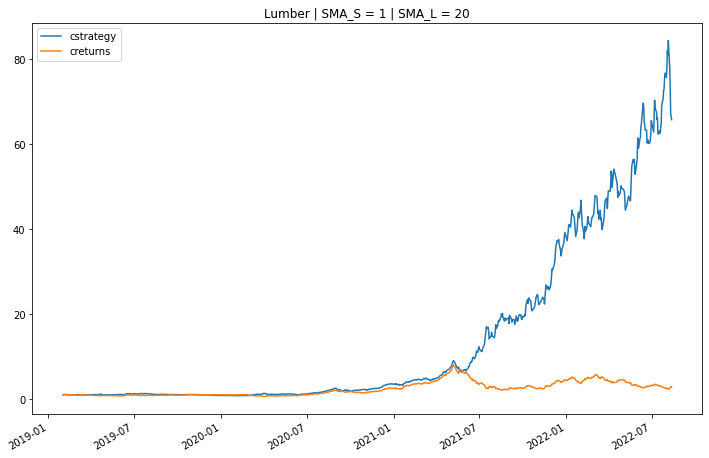

In [ ]:
tester.plot_results()

In [ ]:
tester.data

,Price,returns,SMA_S,SMA_L
2019-01-03,164.743433,-0.011167,164.743433,NaN
2019-01-04,164.943425,0.001213,164.943425,NaN
2019-01-07,165.393407,0.002724,165.393407,NaN
2019-01-08,170.093220,0.028020,170.093220,NaN
2019-01-09,168.143298,-0.011530,168.143298,NaN
...,...,...,...,...
2022-08-08,519.299988,0.080364,519.299988,578.974997
2022-08-09,552.799988,0.062515,552.799988,572.649997
2022-08-10,601.799988,0.084929,601.799988,568.574997
2022-08-11,595.599976,-0.010356,595.599976,566.054996


In [ ]:
tester.results

,Price,returns,SMA_S,SMA_L,position,strategy,creturns,cstrategy
2019-02-01,209.591646,0.007182,209.591646,183.232696,1,0.007182,1.000000,1.000000
2019-02-04,211.941552,0.011149,211.941552,185.582603,1,0.011149,1.018501,1.018501
2019-02-05,219.441253,0.034774,219.441253,188.284995,1,0.034774,1.054541,1.054541
2019-02-06,219.741241,0.001366,219.741241,190.767396,1,0.001366,1.055983,1.055983
2019-02-07,212.241540,-0.034726,212.241540,192.972308,1,-0.034726,1.019942,1.019942
...,...,...,...,...,...,...,...,...
2022-08-08,519.299988,0.080364,519.299988,578.974997,-1,-0.080364,2.495534,77.881043
2022-08-09,552.799988,0.062515,552.799988,572.649997,-1,-0.062515,2.656521,73.161407
2022-08-10,601.799988,0.084929,601.799988,568.574997,1,-0.084929,2.891994,67.204429
2022-08-11,595.599976,-0.010356,595.599976,566.054996,1,-0.010356,2.862200,66.512059


<AxesSubplot:>

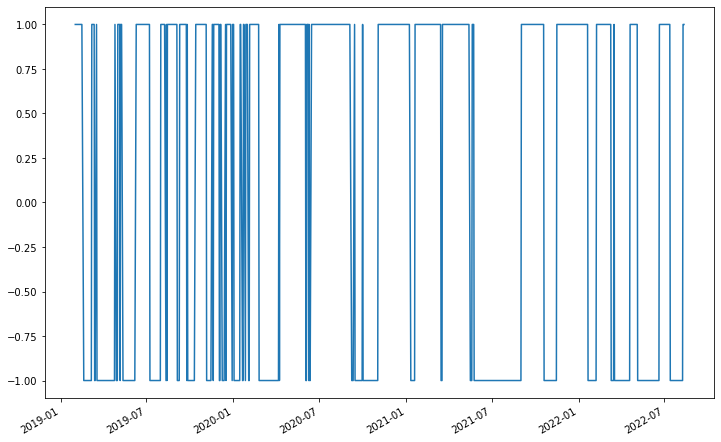

In [ ]:
tester.results.loc[:,'position'].plot(figsize=(12,8));